# Permutation sensitivity
A simple technique for examining feature importance, described in detail [here](https://www.kaggle.com/dansbecker/permutation-importance).

Basic idea: permute our columns. If predictions change, that column must have been important!

In [13]:
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from eli5.sklearn import PermutationImportance
import eli5

### Some example data
Data for California housing prices.

In [2]:
cali_housing = datasets.california_housing.fetch_california_housing()
print(cali_housing.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [3]:
cali_housing_df = pd.DataFrame(cali_housing.data, columns=cali_housing.feature_names)
cali_housing_df = pd.concat((cali_housing_df, pd.DataFrame(cali_housing.target, columns=['price'])), axis=1)

In [4]:
cali_housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


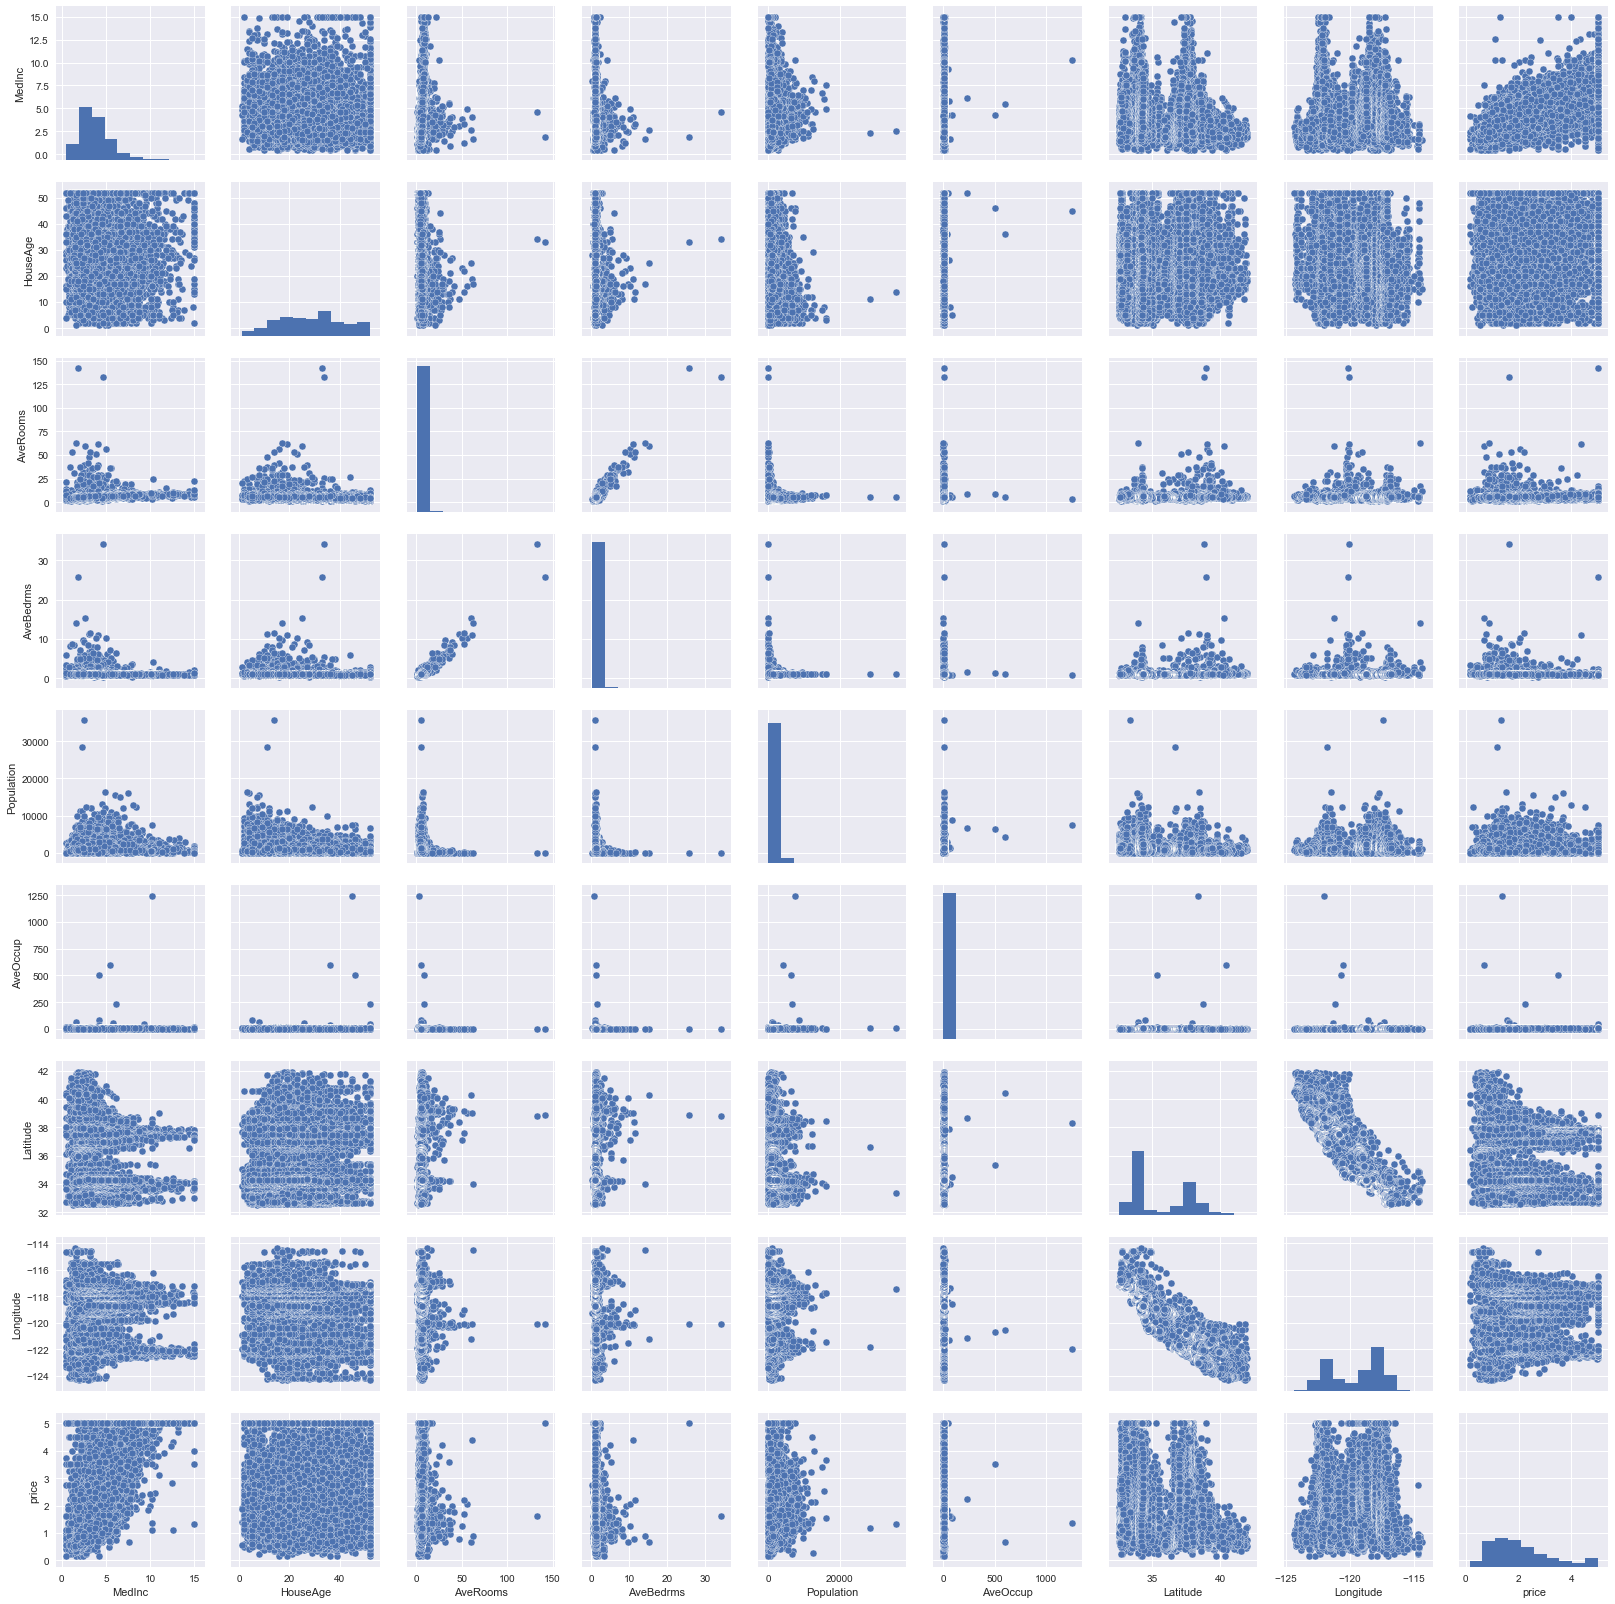

In [33]:
sns.pairplot(cali_housing_df)

## Fit a linear model and examine

In [37]:
lm = LinearRegression(normalize=True)
X = cali_housing_df.values[:, :-1]
y = cali_housing_df.values[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X, y)
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [38]:
perm = PermutationImportance(lm, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = cali_housing_df.columns.values[:-1])

Weight,Feature
1.2375 ± 0.0432,Latitude
1.1999 ± 0.0548,Longitude
1.0141 ± 0.0309,MedInc
0.0841 ± 0.0062,AveBedrms
0.0654 ± 0.0047,AveRooms
0.0194 ± 0.0015,HouseAge
0.0015 ± 0.0003,AveOccup
0.0000 ± 0.0002,Population


Both latitude and longitude are related to value. We might be able to see this more clearly by plotting our data onto a map...

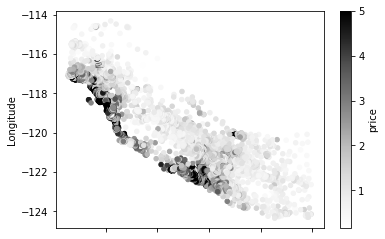

In [39]:
geo_df = cali_housing_df[['Latitude', 'Longitude', 'price']].copy()
cali_housing_df.plot.scatter(x='Latitude', y='Longitude', c='price')

## How does this compare to the coefficients from the regression?

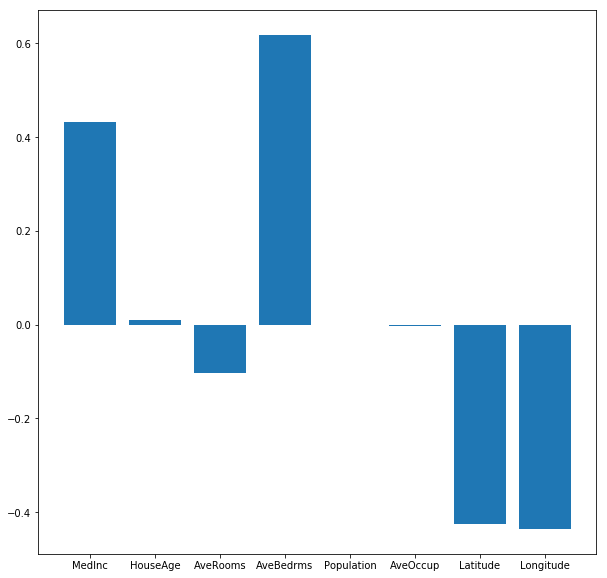

In [41]:
plt.figure(figsize=(10,10))
plt.bar(range(len(lm.coef_)), lm.coef_)
plt.xticks(range(len(lm.coef_)), cali_housing_df.columns.values[:-1])
plt.show()

Note that the relationship between lat/long and price is actually *negative*; being South and West is better than being North and East. However, one suspects there's actually a big interaction here (the important axis is probably North-West --> South-West).

Note also that `AveBedrms` is the `most` important according to the regression parameters, but not according to the permutation test.

I think this is probably because `AveBedrms` and `AveRooms` are highly correlated in the original data. Since permuting `AveBedrms` alone has no effect upon `AveRooms`, we estimate a smaller effect size. In this particular regression result, `AveBedrms` has taken all of the variance, leavin `AveRooms` with a slightly negative parameter value. We can see that this is non-intuitive by plotting `AveRooms` against `price` directly:

Text(0.5, 1.0, 'Price vs. AveRooms')

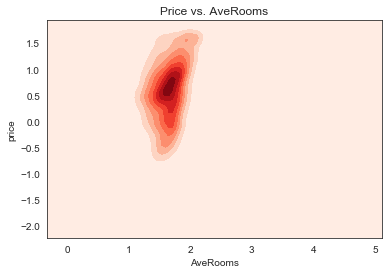

In [60]:
sns.set_style('white')
sns.kdeplot(np.log(cali_housing_df['AveRooms']), np.log(cali_housing_df['price']),
           cmap='Reds', shade=True)
plt.title('Price vs. AveRooms')